In [24]:
import load_nlfff

In [25]:
data = load_nlfff.nlfff("/Users/mgjeon/workspace/AR11158/isee/11158_20110215_013600.nc")

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


In [26]:
import numpy as np

In [27]:
x = np.array(data.x)
y = np.array(data.y)
z = np.array(data.z)

bx = np.array(data.bx)
by = np.array(data.by)
bz = np.array(data.bz)

bx_pot = np.array(data.bx_pot)
by_pot = np.array(data.by_pot)
bz_pot = np.array(data.bz_pot)

In [28]:
bx.shape

(513, 257, 257)

In [29]:
from finite_difference import *

In [46]:
dx = np.mean(x[1:] - x[:-1])
dy = np.mean(y[1:] - y[:-1])
dz = np.mean(z[1:] - z[:-1])

In [47]:
laplace_bx = laplacian(bx, dx, dy, dz)
laplace_by = laplacian(by, dx, dy, dz)
laplace_bz = laplacian(bz, dx, dy, dz)

In [48]:
laplace_b = np.sqrt(laplace_bx**2 + laplace_by**2 + laplace_bz**2)

In [49]:
import matplotlib.pyplot as plt

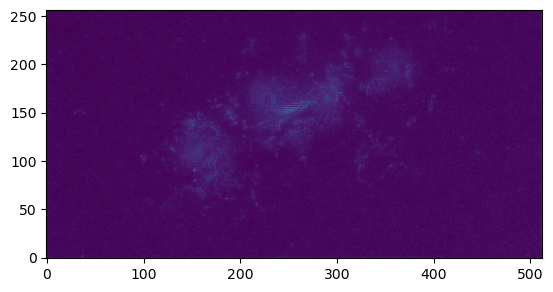

In [50]:
plt.imshow(laplace_b.sum(-1).T, origin='lower')

In [52]:
from scipy.io import netcdf_file

In [53]:
fname = 'laplace_b.nc'

f = netcdf_file(fname, 'w')

nx = len(x)
ny = len(y)
nz = len(z)

f.createDimension('x', nx)
f.createDimension('y', ny)
f.createDimension('z', nz)

xv = f.createVariable('x', 'f', ('x',))
yv = f.createVariable('y', 'f', ('y',))
zv = f.createVariable('z', 'f', ('z',))

xv[:] = x 
yv[:] = y 
zv[:] = z

laplace_bv = f.createVariable('laplace_b', 'f', ('z', 'y', 'x'))
laplace_bv[:, :, :] = laplace_b.transpose(2, 1, 0)

f.close()

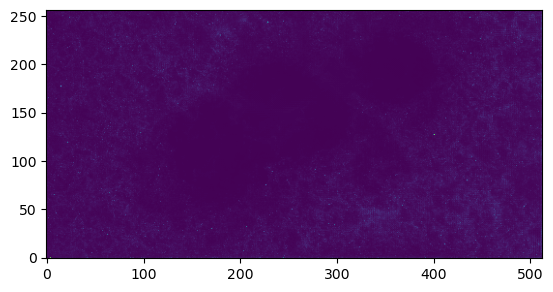

In [54]:
b = np.sqrt(bx**2 + by**2 + bz**2)
normalized_laplace_b = np.divide(laplace_b, b, where=b!=0)
plt.imshow(normalized_laplace_b.sum(-1).T, origin='lower')

In [56]:
fname = 'normalized_laplace_b.nc'

f = netcdf_file(fname, 'w')

nx = len(x)
ny = len(y)
nz = len(z)

f.createDimension('x', nx)
f.createDimension('y', ny)
f.createDimension('z', nz)

xv = f.createVariable('x', 'f', ('x',))
yv = f.createVariable('y', 'f', ('y',))
zv = f.createVariable('z', 'f', ('z',))

xv[:] = x 
yv[:] = y 
zv[:] = z

laplace_bv = f.createVariable('normalized_laplace_b', 'f', ('z', 'y', 'x'))
laplace_bv[:, :, :] = normalized_laplace_b.transpose(2, 1, 0)

f.close()

In [60]:
Bfield = np.stack([bx, by, bz], axis=-1)

In [61]:
nx, ny, nz = bx.shape

In [90]:
MAD_scalar_field = np.zeros((nx, ny, nz))

# for i in range(nx):
#     for j in range(ny):
#         for k in range(nz):

i = 2
j = 3
k = 4

B_at_point = Bfield[i, j, k]

adjacent_indices = [
    (i - 1, j, k), 
    (i + 1, j, k),  
    (i, j - 1, k),  
    (i, j + 1, k), 
    (i, j, k - 1),  
    (i, j, k + 1), 
]

angles = []

for adj_x, adj_y, adj_z in adjacent_indices:
    if 0 <= adj_x < nx and 0 <= adj_y < ny and 0 <= adj_z < nz:
        adjacent_vector = Bfield[adj_x, adj_y, adj_z]
        nu = np.dot(B_at_point, adjacent_vector)
        de = np.linalg.norm(B_at_point) * np.linalg.norm(adjacent_vector)
        angle = np.rad2deg(np.arccos(np.divide(nu, de, where=de!=0)))
        angles.append(angle)

maximum_angle = max(angles)

MAD_scalar_field[i, j, k] = maximum_angle

In [91]:
MAD_scalar_field[i, j, k]

10.45736500672462

In [103]:
B_at_point = Bfield[1:-1, 1:-1, 1:-1]
B_aj_x1 = Bfield[0:-2, 1:-1, 1:-1]
B_aj_x2 = Bfield[2:, 1:-1, 1:-1]
B_aj_y1 = Bfield[1:-1, 0:-2, 1:-1]
B_aj_y2 = Bfield[1:-1, 2:, 1:-1]
B_aj_z1 = Bfield[1:-1, 1:-1, 0:-2]
B_aj_z2 = Bfield[1:-1, 1:-1, 2:]

def get_angle(at_point, ad_point):
    inner_product = np.sum((at_point*ad_point), -1)
    norm = np.linalg.norm(at_point, axis=-1) * np.linalg.norm(ad_point, axis=-1)
    return np.rad2deg(np.arccos(inner_product/norm))

In [107]:
angle_x1 = get_angle(B_at_point, B_aj_x1)
angle_x2 = get_angle(B_at_point, B_aj_x2)
angle_y1 = get_angle(B_at_point, B_aj_y1)
angle_y2 = get_angle(B_at_point, B_aj_y2)
angle_z1 = get_angle(B_at_point, B_aj_z1)
angle_z2 = get_angle(B_at_point, B_aj_z2)

/var/folders/d4/xhfvv5n927b6pg81whlh7qxr0000gn/T/ipykernel_2782/958861327.py:12: RuntimeWarning: invalid value encountered in divide
  return np.rad2deg(np.arccos(inner_product/norm))


In [108]:
angles = np.stack([angle_x1, angle_x2, angle_y1, angle_y2, angle_z1, angle_z2])

In [111]:
max_angle = np.max(angles, axis=0)

In [113]:
MAD_field = np.zeros((nx, ny, nz))

In [114]:
MAD_field[1:-1, 1:-1, 1:-1] = max_angle

In [115]:
MAD_field[i, j, k]

10.45736500672462

In [117]:
fname = 'mad.nc'

f = netcdf_file(fname, 'w')

nx = len(x)
ny = len(y)
nz = len(z)

f.createDimension('x', nx)
f.createDimension('y', ny)
f.createDimension('z', nz)

xv = f.createVariable('x', 'f', ('x',))
yv = f.createVariable('y', 'f', ('y',))
zv = f.createVariable('z', 'f', ('z',))

xv[:] = x 
yv[:] = y 
zv[:] = z

mad_v = f.createVariable('MAD', 'f', ('z', 'y', 'x'))
mad_v[:, :, :] = MAD_field.transpose(2, 1, 0)

f.close()